In [1]:
#-----------------------#
#        Imports        #
#-----------------------#
working_dir = '/Users/kmohamad/Documents/GitHub/SIP2019/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import requests
import glob
import re
import sys

sys.path.append(working_dir + 'lib')

from astropy.io import fits, ascii
from astropy.table import Table
from os import path
from py_specrebin import rebinspec

In [2]:
# Speed of light in km/s
C = 299792

In [3]:
polyval_results = np.load(working_dir + 'Kadri/galaxy_LSF_output/COSMOS.deltaLambdaFit.npy')
polyval_results = polyval_results[:,0]
delta_lambda_function = np.poly1d(polyval_results)

In [4]:
#-----------------------#
#    API Integration    #
#-----------------------#

# API integration to send emails when the code is done running
def send_simple_message():
    return requests.post(
        "https://api.mailgun.net/v3/sandbox1859aa1e747740578e897d1d8d07469f.mailgun.org/messages",
        auth=("api", "f7cede1a6d4568b38b0837c2d2c7efe6-2b778fc3-74f1176e"),
        data={"from": "Spectra Coadd 2 <mailgun@sandbox1859aa1e747740578e897d1d8d07469f.mailgun.org>",
            "to": ["kadri.mnizam@gmail.com"],
            "subject": "Script Finished Running",
            "text": "The spectra coadd script has finished running!"})

In [5]:
#-----------------------#
#   Class Definitions   #
#-----------------------#

class HDU_Reader:
    
    def __init__(self, hdu, catalog, wavelength_range):
        
        try:
            if 'Bxspf-B' in hdu and 'Bxspf-R' in hdu:
                blue_name = 'Bxspf-B'
                red_name = 'Bxspf-R'
            else:
                blue_name = 'Horne-B'
                red_name = 'Horne-R'
                
            blue = Spectrum(hdu[blue_name].data)
            red = Spectrum(hdu[red_name].data)
            
        except KeyError:
            return None
        
        self.wavelength = wavelength_range
        self.spectra, self.ivar = np.nan_to_num(
            rebinspec(
                self.correct_lambda_shifts(np.append(blue.wavelength, red.wavelength), catalog),
                np.append(blue.flux, red.flux),
                wavelength_range,
                ivar = np.append(blue.ivar, red.ivar)
            )
        )
        
    def correct_lambda_shifts(self, wavelength, obj):
        pass
        # Correct for A-Band
        delta_lambda = obj['ABANDCOR'] * 7600 * delta_lambda_function(wavelength) / (C * delta_lambda_function(7600))
        wavelength -= delta_lambda
        
        # Correct for doppler shift
        wavelength /=  (1 + obj['VOBS']/C)
             
        return wavelength
    
    
class Spectrum:
    
    def __init__(self, hdu):
        self.wavelength = hdu['LAMBDA'][0]
        self.flux = hdu['SPEC'][0]
        self.ivar = hdu['IVAR'][0]

In [6]:
#-----------------------#
#  Function Definitions #
#-----------------------#
def sigma_clipping(flux, sigma):
    clip = np.ones(np.shape(flux))
    std = np.std(flux, axis = 0)
    gaus_mid = np.mean(flux, axis = 0)
    
    clip[np.abs(flux - gaus_mid) > sigma * std] = 0
    
    return np.nan_to_num(clip)

def coadd(spectra, ivar, sigma):    
    spectra = np.nan_to_num(spectra)
    ivar = np.nan_to_num(ivar)

    clip = sigma_clipping(spectra, sigma)
    coadd_spectra = np.nan_to_num(np.sum(spectra * ivar * clip, axis = 0) / np.sum(ivar * clip, axis = 0))
    coadd_ivar = np.nan_to_num(np.sum(ivar * clip, axis = 0))
    coadd_err = np.nan_to_num(1 / np.sqrt(np.sum(ivar * clip, axis = 0)))

    return coadd_spectra, coadd_ivar, coadd_err

In [7]:
catalog = pd.read_csv(working_dir + '/Kadri/sip_catalog.csv')
catalog.set_index(['OBJ_TYPE','SPEC1DNAME'], inplace = True)

In [8]:
collections.Counter(catalog.index.get_level_values(0))

Counter({'DE_GC': 88,
         'UDG_GC': 23,
         'Star': 354,
         'IGC': 35,
         'M87_GC': 25,
         'UNK': 1,
         'DE_NUC': 21})

In [9]:
fits_file = glob.glob(working_dir + '/spectra/*.fits')
gz_file = glob.glob(working_dir + '/spectra/*.gz')

files = np.append(fits_file, gz_file)

In [10]:
l_initial = 4000
l_final = 8950.9
l_sampling = 0.9
wavelength_range = np.arange(l_initial, l_final, l_sampling)

norm_region = {
    'Mg_Trip':[5100, 5200],
    'Ha':[6500, 6600],
    'Ca_Trip':[8400, 8700]
}

sigma = 3

In [11]:
if False:

    stacked_spectra = np.zeros((catalog.shape[0], wavelength_range.shape[0]))
    stacked_ivar = np.zeros((catalog.shape[0], wavelength_range.shape[0]))

    row_ind = 0

    for ind, row in catalog.iterrows():

        file_path = working_dir + 'spectra/' + ind[1]

        if path.exists(file_path):
            f = fits.open(file_path)
        elif path.exists(file_path[:-3]):
            f = fits.open(file_path[:-3])
        else:
            print(row.name)
            raise FileNotFoundError

        data = HDU_Reader(f, row, wavelength_range)

        stacked_spectra[:][row_ind] = data.spectra
        stacked_ivar[:][row_ind] = data.ivar

        f.close()
        row_ind += 1

    np.savetxt(working_dir + 'Kadri/' + 'stacked_spectra.csv', stacked_spectra, delimiter = ',')
    np.savetxt(working_dir + 'Kadri/' + 'stacked_ivar.csv', stacked_ivar, delimiter = ',')

    send_simple_message()

In [12]:
spectra = {}
ivar = {}
err = {}

stacked_spectra = {}
stacked_ivar = {}

In [13]:
spec = np.loadtxt(working_dir + 'Kadri/stacked_spectra.csv', delimiter = ',')
ivar = np.loadtxt(working_dir + 'Kadri/stacked_spectra.csv', delimiter = ',')

for region in norm_region:
    stacked_spectra[region] = np.zeros_like(spec)
    stacked_ivar[region] = np.zeros_like(ivar)
    
    for ind, row in enumerate(spec):
        med = np.median(
            row[(wavelength_range >= norm_region[region][0]) & (wavelength_range <= norm_region[region][1])]
        )

        stacked_spectra[region][:][ind] = row/med
        stacked_ivar[region][:][ind] = row*(med**2)

In [16]:
# We create dictionaries that will hold the coadded spectra of the different normalized regions, for the
# different category of objects

coadded_spec = {}
coadded_ivar = {}
coadded_err = {}

for region in norm_region:
    
    coadded_spec[region] = {}
    coadded_ivar[region] = {}
    coadded_err[region] = {}
    
    for cat in ['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC', 'ALL']:
        if not cat is 'ALL':
            ind = np.where(catalog.index.get_level_values(0) == cat)
        else:
            ind = range(0, len(catalog))
            
        spectra, ivar, err = coadd(stacked_spectra[region][ind], stacked_ivar[region][ind], 3)
        
        coadded_spec[region].update({cat:spectra})
        coadded_ivar[region].update({cat:ivar})
        coadded_err[region].update({cat:err})
        

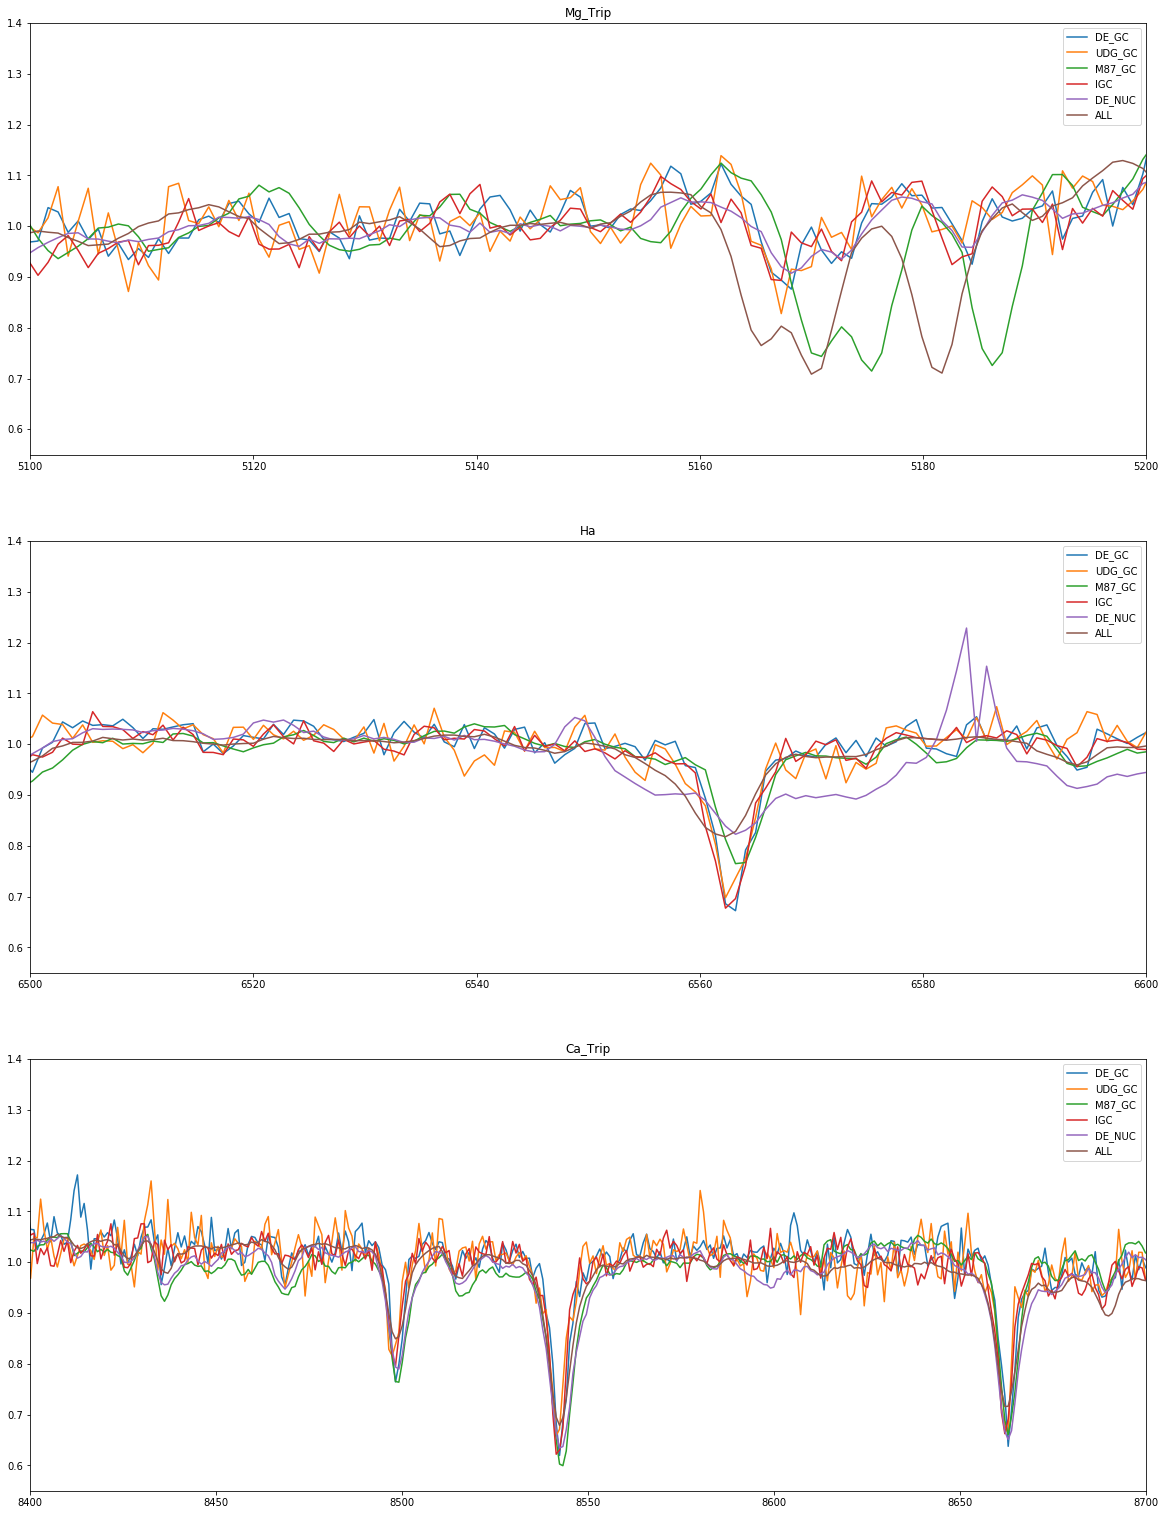

In [18]:
# Plot the different category of objects, based on the different regions

fig, ax = plt.subplots(3, 1, sharey = True, figsize = (20,27))


for ind, region in enumerate(norm_region):
    for cat in coadded_spec[region]:
        ax[ind].plot(wavelength_range, coadded_spec[region][cat])
        ax[ind].set_xlim(norm_region[region])
        ax[ind].set_ylim((0.55, 1.4))
        
    ax[ind].title.set_text(region)
    legend = [x for x in coadded_spec[region]]
    ax[ind].legend(legend)

In [19]:
files = catalog[catalog['CATALOG'] == 'VDGC'].index.get_level_values(level = 1).values
skysigma = np.zeros_like(files)

for ind, file in enumerate(files):
    
    file_path = working_dir + 'spectra/' + file

    if path.exists(file_path):
        f = fits.open(file_path)
    elif path.exists(file_path[:-3]):
        f = fits.open(file_path[:-3])
    else:
        print(row.name)
        raise FileNotFoundError
    
    skysigma[ind] = f['Horne-B'].header['SKYSIGMA']
    f.close()
    

In [20]:
median_skysig = np.median(skysigma)

FWHM_inst = median_skysig * 2.35
delta_FWHM = np.sqrt(5**2 - FWHM_inst**2)

In [ ]:
hdr = fits.Header()
hdr['NAXIS1'] = 5501
hdr['NAXIS2'] = 6
hdr['CRVAL1'] = 4000
hdr['CDELT1'] = 0.9
hdu = fits.PrimaryHDU(list(spectra.values()), header=hdr)
hdu.writeto('test.fits', overwrite = True)

In [ ]:
region = 'Ha'

spectra = {}
ivar = {}
err = {}

for cat in ['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC', 'ALL']:
    if not cat is 'ALL':
        ind = np.where(catalog.index.get_level_values(0) == cat)
    else:
        ind = range(0, len(catalog))
        
    spectra[cat], ivar[cat], err[cat] = coadd(stacked_spectra[region][ind], stacked_ivar[region][ind], 3)
    
    
plt.figure(figsize = (20, 15))

for ind, cat in enumerate(['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC', 'ALL']):
    plt.plot(wavelength_range, spectra[cat])

plt.xlim((norm_region[region]))
plt.legend(['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC', 'ALL'])
plt.ylim((0.5, 1.2))

In [ ]:
plt.figure(figsize = (20, 15))

for ind, cat in enumerate(['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC']):
    plt.plot(wavelength_range, spectra[cat])
    
plt.xlim((norm_region['Mg_Trip']))
plt.legend(['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC'])
plt.ylim((0.5, 1.2))

In [ ]:
def plot_spectra(catalog, file, region):
    
    stacked_spectra = np.loadtxt(file[0], dtype = float, delimiter = ',')
    stacked_ivar = np.loadtxt(file[1], dtype = float, delimiter = ',')
    
    for cat in ['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC', 'ALL']:
        if not cat is 'ALL':
            ind = np.where(catalog.index.get_level_values(0) == cat)
        else:
            ind = range(0, len(catalog))

        spectra[cat], ivar[cat], err[cat] = coadd(stacked_spectra[ind], stacked_ivar[ind], 3)

    
    plt.figure(figsize = (20, 12))

    for cat in ['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC']:
        plt.plot(wavelength_range, spectra[cat])

    plt.xlim((region[0], region[1]))
    plt.legend(['DE_GC', 'UDG_GC', 'M87_GC', 'IGC', 'DE_NUC'])
    
    return spectra, ivar, err

In [ ]:
# Folders are Ha, Mg Triplet, Ca Triplet

region = 'Ca_Trip'

file = [
    working_dir + 'Kadri/' + region + '/stacked_spectra.csv',
    working_dir + 'Kadri/' + region + '/stacked_ivar.csv'
]

spectra, ivar, err = plot_spectra(catalog, file, norm_region[region])
plt.ylim((0.5, 1.2))

In [ ]:
# import seaborn as sns

# sns.set_context("talk")
# # seaborn.set()

# file = ['COSMOS.deltaLambdaFit.npy', 'EGS.deltaLambdaFit.npy', 'GOODSN.deltaLambdaFit.npy', 'GOODSS.deltaLambdaFit.npy']

# x = np.linspace(0,10000,1e+5)
# y = np.zeros_like(x)

# plt.figure(figsize = (15,8))
# plt.rc('font', family='Times New Roman', size = 25)

# for f in file:
#     polykev = np.load(working_dir + 'Kadri/galaxy_LSF_output/' + f)
#     polykev = np.poly1d(polykev[:,0])
#     plt.plot(x, polykev(x))
#     y += polykev(x)
    
# plt.plot(x, y/4, '--', color='black')
    
# plt.title('Kevin\'s Polynomial')
# plt.legend(['COSMOS', 'EGS', 'GOODSN', 'GOODSS', 'Average'], frameon = False)
# plt.minorticks_on()

# ax = plt.gca()
# # ax.xaxis.set_ticks_position('both')
# # ax.yaxis.set_ticks_position('both')
# ax.tick_params(which='major', width=2, length=10, direction='in')
# ax.tick_params(which='minor', width=2, length=4, direction='in')

# plt.savefig('polykev.pdf')